[Datitos: Aprendizaje profundo](https://datitos.github.io/curso-aprendizaje-profundo/)

[T.P. N°2 - Aprendizaje Profundo 2021 by Datitos](https://www.kaggle.com/c/tp-n2-aprendizaje-profundo-2021-by-datitos-v2)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../lib')

In [136]:
import numpy as np
import pandas as pd

import torch
from torch.nn import Sequential, Softmax
from torch.optim import Adam

from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split

from callbacks import PlotLosses, \
                      Logger, \
                      ReduceLROnPlateau, \
                      TrainValLossComputer

from model import CommonModel, \
                  softmax_cross_entropy_fn, \
                  softmax_pred_out, \
                  linear_relu_dropout

from utils import try_gpu
from callbacks import CallbackSet

from metrics import show_summary

In [88]:
train_set = pd.read_csv('./dataset/fifa2021_training.csv')

In [89]:
# ProfileReport(train_set, title="Exploratory Analisys", explorative=True)to_file("report.html")

In [90]:
SKILL_FEATURES = [
    'BallControl', 'Dribbling', 'Marking', 'SlideTackle', 'StandTackle', 'Aggression',
    'Reactions', 'Interceptions', 'Vision', 'Composure', 'Crossing', 'ShortPass',
    'LongPass', 'Acceleration', 'Stamina', 'Strength', 'Balance', 'SprintSpeed',
    'Agility', 'Jumping', 'Heading', 'ShotPower', 'Finishing', 'LongShots',
    'Curve', 'FKAcc', 'Penalties', 'Volleys', 'GKDiving', 'GKHandling',
    'GKKicking', 'GKReflexes'
]
TARGET = 'Position'

In [91]:
def preprocess(df): return df[SKILL_FEATURES], pd.get_dummies(df[[TARGET]], dummy_na=True)

In [92]:
X, y = preprocess(train_set)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((11136, 32), (11136, 5), (2785, 32), (2785, 5))

In [93]:
class MyModel(CommonModel):
    def __init__(self, X_train, y_train, lr=0.001, dropout=0.2):
        n_hidden_1 = 15
        n_hidden_2 = 5
        model = Sequential(
            linear_relu_dropout(X_train.shape[1], n_hidden_1,       dropout),
            linear_relu_dropout(n_hidden_1,       n_hidden_2,       dropout),
            linear_relu_dropout(n_hidden_2,       y_train.shape[1], dropout),
            Softmax(dim=1)
        ).to(device=try_gpu())

        super().__init__(
            model            = model, 
            loss             = softmax_cross_entropy_fn,
            optimizer        = Adam(model.parameters(), lr=lr),
            conv_pred_out_fn = softmax_pred_out
        )

In [94]:
model = MyModel(X_train, y_train).info()

Model:
 Sequential(
  (0): Sequential(
    (0): Linear(in_features=32, out_features=15, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (1): Sequential(
    (0): Linear(in_features=15, out_features=5, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (2): Sequential(
    (0): Linear(in_features=5, out_features=5, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (3): Softmax(dim=1)
)
Params:
 [('0.0.weight', torch.Size([15, 32])), ('0.0.bias', torch.Size([15])), ('1.0.weight', torch.Size([5, 15])), ('1.0.bias', torch.Size([5])), ('2.0.weight', torch.Size([5, 5])), ('2.0.bias', torch.Size([5]))]


### Train

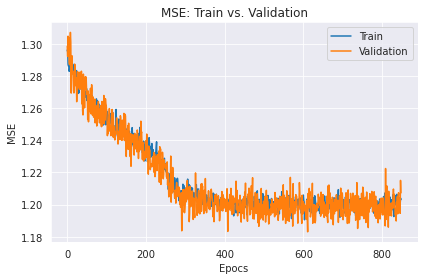

{'epoch': 900, 'lr': 1.0000000000000004e-08, 'train_loss': 1.1995795965194702, 'val_loss': 1.1947139501571655}


In [95]:
model = MyModel(X_train, y_train)

model.fit(
    train_set    = (X_train, y_train), 
    val_set      = (X_val, y_val),
    batch_size   = 2000,
    epochs       = 900,
    callback_set = CallbackSet([
        TrainValLossComputer(),
        PlotLosses(warmup_count=50),
        Logger(metrics=['epoch', 'train_loss', 'val_loss', 'lr']),
        ReduceLROnPlateau(patience=100)
    ])
)

### Predict

In [145]:
y_true = pd.DataFrame({ 'y_true': np.argmax(y_val.values, axis=1)})
y_pred = pd.DataFrame({ 'y_true': model.predict(X_val)})

Accuracy: 74.4345 %

Classification Report:
              precision    recall  f1-score   support

Position_DEF       0.70      0.86      0.77       918
Position_FWD       0.72      0.67      0.70       548
 Position_GK       0.85      0.76      0.80       297
Position_MID       0.78      0.68      0.73      1022

    accuracy                           0.74      2785
   macro avg       0.76      0.74      0.75      2785
weighted avg       0.75      0.74      0.74      2785



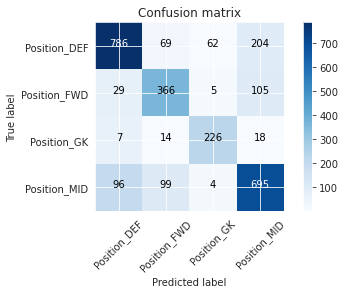

In [146]:
show_summary(y_true, y_pred, labels=list(y_val.columns.values))